In [2]:
#Importing necessary dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split 
from datetime import datetime
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

from plotly.subplots import make_subplots
%matplotlib inline
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile


2023-10-06 13:14:45.822874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 13:14:45.928460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 13:14:45.928477: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-06 13:14:45.950907: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-06 13:14:46.413299: W tensorflow/stream_executor/pla

In [3]:
# Creating models
# causal conv
def __causal_gated_conv1D(x=None, filters=16, length=6, strides=1):
    def causal_gated_conv1D(x, filters, length, strides):
        x_in_1 = layers.Conv1D(filters=filters // 2,
                               kernel_size=length,
                               dilation_rate=strides, 
                               strides=1,
                               padding="causal")(x)
        x_sigmoid = layers.Activation(activation="sigmoid")(x_in_1)

        x_in_2 = layers.Conv1D(filters=filters // 2,
                               kernel_size=length,
                               dilation_rate=strides,  
                               strides=1,
                               padding="causal")(x)
        x_tanh = layers.Activation(activation="tanh")(x_in_2)

        x_out = layers.Multiply()([x_sigmoid, x_tanh])

        return x_out

    if x is None:
        return lambda _x: causal_gated_conv1D(x=_x, filters=filters, length=length, strides=strides)
    else:
        return causal_gated_conv1D(x=x, filters=filters, length=length, strides=strides)


In [4]:
def Net(input_shape, classes, width_multiply=1):
    _x_in = layers.Input(shape=input_shape)

    # 1 block
    _x_up = __causal_gated_conv1D(filters=16 * width_multiply, length=3)(_x_in)
    _x_down = __causal_gated_conv1D(filters=16 * width_multiply, length=6)(_x_in)
    _x = layers.Concatenate()([_x_up, _x_down])

    # 2 block
    _x_up = __causal_gated_conv1D(filters=8 * width_multiply, length=3)(_x)
    _x_down = __causal_gated_conv1D(filters=8 * width_multiply, length=6)(_x)
    _x = layers.Concatenate()([_x_up, _x_down])

    # 3 block
    _x_up = __causal_gated_conv1D(filters=8 * width_multiply, length=3)(_x)
    _x_down = __causal_gated_conv1D(filters=8 * width_multiply, length=6)(_x)
    _x_concat = layers.Concatenate()([_x_up, _x_down])

    _x = layers.Add()([_x, _x_concat])

    # 4 block
    _x_loop1 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=3)(_x)
    _x = layers.Add()([_x, _x_loop1])

    # 5 block
    _x_loop2 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)
    _x = layers.Add()([_x, _x_loop2])

    # 6 block
    _x_loop3 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)
    _x = layers.Add()([_x, _x_loop3])

    # 7 block
    _x_forward = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)

    # 8 block
    _x_loop4 = __causal_gated_conv1D(filters=32 * width_multiply, length=3, strides=2)(_x)

    # output
    _x = layers.Concatenate()([_x_loop2, _x_loop3, _x_forward, _x_loop4])
    _x = layers.Conv1D(filters=classes, kernel_size=1)(_x)
    _x = layers.GlobalAveragePooling1D()(_x)
    _x = layers.Activation("softmax")(_x)

    model = models.Model(inputs=_x_in, outputs=_x)

    return model

In [5]:
# Load the training data
X_train = np.load('/home/sae/training_data.npy')
y_train = np.load('/home/sae/training_labels.npy')

# Load the validation data (
X_validation = np.load('/home/sae/validation_data.npy')
y_validation = np.load('/home/sae/validation_labels.npy')

# Load the test data
X_test = np.load('/home/sae/testing_data.npy')
y_test = np.load('/home/sae/testing_labels.npy')

In [6]:
model = Net(input_shape=(40,87), classes=2,width_multiply=2) 
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
# Display model architecture summary
model.summary()

2023-10-06 13:14:55.208215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-06 13:14:55.208332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-06 13:14:55.208414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-06 13:14:55.208493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-06 13:14:55.208572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 87)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 40, 16)       4192        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 40, 16)       4192        ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 40, 16)       8368        ['input_1[0][0]']                
                                                                                              

In [7]:
#recision/recall calculation - use 0.7 threshold for now, do not run this code unless we want to test out recall/precision
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

#Store accuracy and precision/recall
fold_precisions = []
fold_recalls = []

#F1 scores
fold_f1_scores = []
fold_half_scores = []
fold_double_scores = []

# Initialize an array of threshold values (e.g., from 0.1 to 0.9)
thresholds = np.arange(0.1, 1.0, 0.1)

#save confusion matrix
fold_cm = []

le = LabelEncoder()
num_epochs = 3
num_batch_size = 32

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Shuffle the validation data (if needed)
X_validation, y_validation = shuffle(X_validation, y_validation, random_state=42)

# Shuffle the test data
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Train the model

le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_validation_encoded = to_categorical(le.transform(y_validation))
y_test_encoded = to_categorical(le.transform(y_test))



# Train the model
num_epochs = 3
num_batch_size = 32

history = model.fit(X_train, y_train_encoded, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_validation, y_validation_encoded), verbose=1)

# Evaluate the model on the final test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

# Predict on the test set (this should give prediction and associated probabilities)
y_test_pred = model.predict(X_test)

for threshold in thresholds:
    y_test_pred_thresholded = (y_test_pred[:, 1] > threshold).astype(int)  # Adjust the column index if needed
    cm = confusion_matrix(y_test_encoded[:, 1], y_test_pred_thresholded)

    # Calculate TP, FP, FN for the current threshold
    precision = precision_score(y_test_encoded[:, 1], y_test_pred_thresholded)
    recall = recall_score(y_test_encoded[:, 1], y_test_pred_thresholded) 

    # Calculate F1 score using precision and recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fhalf = (1 + 0.5**2) * (precision * recall) / (0.5**2 * precision + recall) if (precision + recall) > 0 else 0
    fdouble = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if (precision + recall) > 0 else 0
    
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_cm.append(cm)
    fold_f1_scores.append(f1)
    fold_half_scores.append(fhalf)
    fold_double_scores.append(fdouble)


Epoch 1/3
437/437 [==============================] - 11s 21ms/step - loss: 0.4649 - accuracy: 0.7689 - val_loss: 0.3713 - val_accuracy: 0.8330
Epoch 2/3
437/437 [==============================] - 9s 20ms/step - loss: 0.2743 - accuracy: 0.8842 - val_loss: 0.2770 - val_accuracy: 0.8871
Epoch 3/3
34/34 [==============================] - 0s 7ms/step - loss: 0.2798 - accuracy: 0.8833
Test loss: 0.2798, Test accuracy: 0.8833
34/34 [==============================] - 1s 6ms/step


In [12]:
from sklearn.model_selection import StratifiedKFold
import numpy as np


k = 10 # 10 fold validation
cv = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

#Combine training, validation, and testing data
X_combined = np.concatenate((X_train, X_validation))
y_combined = np.concatenate((y_train, y_validation))
X_combined, y_combined = shuffle(X_combined, y_combined, random_state = 42)
print(len(X_combined))
print(len(y_combined))

#Store accuracy
results = []

#Store training and validation indices for each fold
train_indices = []
validation_indices = []

#split the data into k folds
for train_idx, val_idx in cv.split(X_combined, y_combined):
    train_indices.append(train_idx)
    validation_indices.append(val_idx)
    
#Perform k-fold cross-validation
for fold in range(k):
    train_idx = train_indices[fold]
    val_idx = validation_indices[fold]
    
    X_train_fold, y_train_fold = X_combined[train_idx], y_combined[train_idx]
    X_val_fold, y_val_fold = X_combined[val_idx], y_combined[val_idx]
    print("X_train_fold shape:", X_train_fold.shape)
    print("y_train_fold shape:", y_train_fold.shape)

    
    y_train_encoded = to_categorical(le.fit_transform(y_train_fold))
    y_validation_encoded = to_categorical(le.transform(y_val_fold))
    print("X_train_fold shape:", X_train_fold.shape)
    print("y_train_encoded shape:", y_train_encoded.shape)

    
    #Compile a model
    model = Net(input_shape=(40,87), classes=2,width_multiply=2) 
    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
    # # Display model architecture summary
    # model.summary()
    
    # Train your model on X_train_fold and y_train_fold
    history = model.fit(X_train_fold, y_train_encoded, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val_fold, y_validation_encoded), verbose=1)

    # Make predictions on the testing set
    y_test_pred = model.predict(X_test)
    y_test_pred_thresholded = (y_test_pred[:, 1] > 0.7).astype(int)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_test_pred_thresholded)
    results.append(fold_accuracy)

# Calculate mean and standard deviation of accuracy scores
mean_accuracy = np.mean(results)
std_accuracy = np.std(results)


16782
16782
X_train_fold shape: (15103, 40, 87)
y_train_fold shape: (15103,)
X_train_fold shape: (15103, 40, 87)
y_train_encoded shape: (15103, 2)
Epoch 1/3
472/472 [==============================] - 11s 20ms/step - loss: 0.4648 - accuracy: 0.7626 - val_loss: 0.3155 - val_accuracy: 0.8702
Epoch 2/3
472/472 [==============================] - 9s 19ms/step - loss: 0.2759 - accuracy: 0.8835 - val_loss: 0.2562 - val_accuracy: 0.8993
Epoch 3/3
34/34 [==============================] - 0s 6ms/step
X_train_fold shape: (15103, 40, 87)
y_train_fold shape: (15103,)
X_train_fold shape: (15103, 40, 87)
y_train_encoded shape: (15103, 2)
Epoch 1/3
472/472 [==============================] - 11s 20ms/step - loss: 0.4524 - accuracy: 0.7709 - val_loss: 0.3320 - val_accuracy: 0.8553
Epoch 2/3
472/472 [==============================] - 9s 19ms/step - loss: 0.2531 - accuracy: 0.8941 - val_loss: 0.2208 - val_accuracy: 0.9101
Epoch 3/3
34/34 [==============================] - 0s 6ms/step
X_train_fold shape: (1

In [13]:
#Print results from k fold cross validation

for i in range(k):
    print("Fold: ", i + 1, " Accuracy: ", results[i])

print("Mean acuracy: ", mean_accuracy)

#Use this to compare performance across different models

Fold:  1  Accuracy:  0.8832720588235294
Fold:  2  Accuracy:  0.8584558823529411
Fold:  3  Accuracy:  0.8998161764705882
Fold:  4  Accuracy:  0.7398897058823529
Fold:  5  Accuracy:  0.8943014705882353
Fold:  6  Accuracy:  0.8869485294117647
Fold:  7  Accuracy:  0.8556985294117647
Fold:  8  Accuracy:  0.8786764705882353
Fold:  9  Accuracy:  0.8308823529411765
Fold:  10  Accuracy:  0.8704044117647058
Mean acuracy:  0.8598345588235293


Fold 0.1   Precision:  0.7886676875957122   Recall:  0.9466911764705882
F1 Score:  0.860484544695071 F-0.5 Score:  0.8159062103929023 F-2 Score:  [0.9102156238953695, 0.8996786861835059, 0.8942065491183879, 0.8792603335750545, 0.8688524590163934, 0.8665447897623402, 0.8599779492833517, 0.8518107908351812, 0.8379992534527809]

Fold 0.2   Precision:  0.8064   Recall:  0.9264705882352942
F1 Score:  0.8622754491017964 F-0.5 Score:  0.8278580814717477 F-2 Score:  [0.9102156238953695, 0.8996786861835059, 0.8942065491183879, 0.8792603335750545, 0.8688524590163934, 0.8665447897623402, 0.8599779492833517, 0.8518107908351812, 0.8379992534527809]

Fold 0.30000000000000004   Precision:  0.824212271973466   Recall:  0.9136029411764706
F1 Score:  0.8666085440278989 F-0.5 Score:  0.8406630581867388 F-2 Score:  [0.9102156238953695, 0.8996786861835059, 0.8942065491183879, 0.8792603335750545, 0.8688524590163934, 0.8665447897623402, 0.8599779492833517, 0.8518107908351812, 0.8379992534527809]

Fold 0.4   

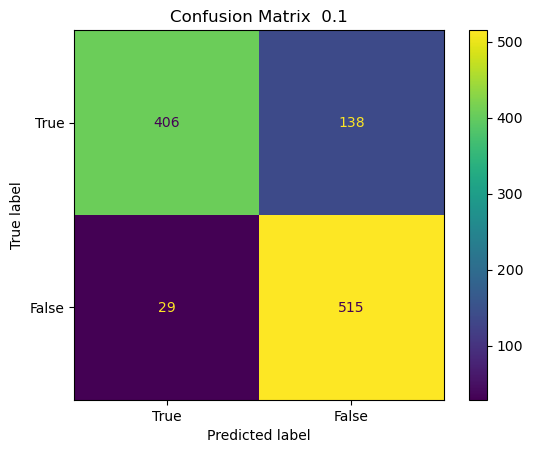

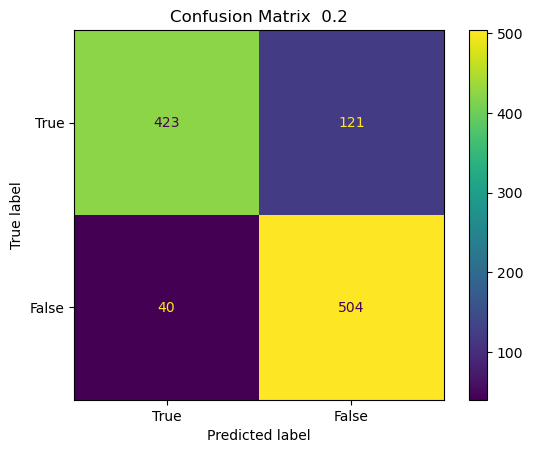

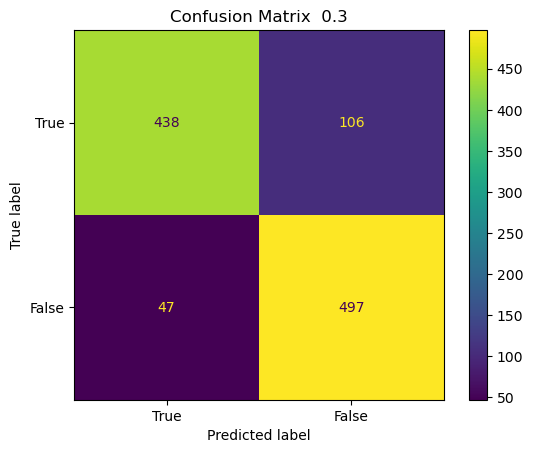

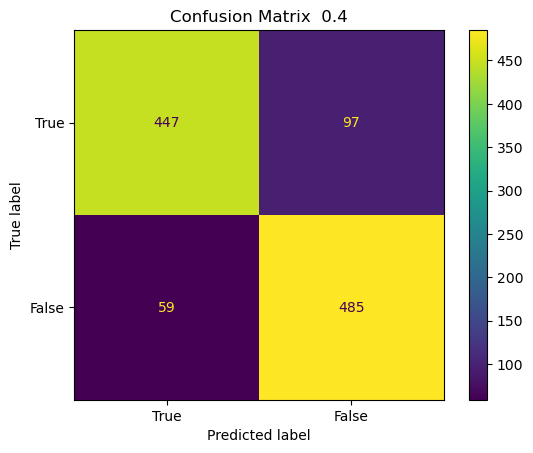

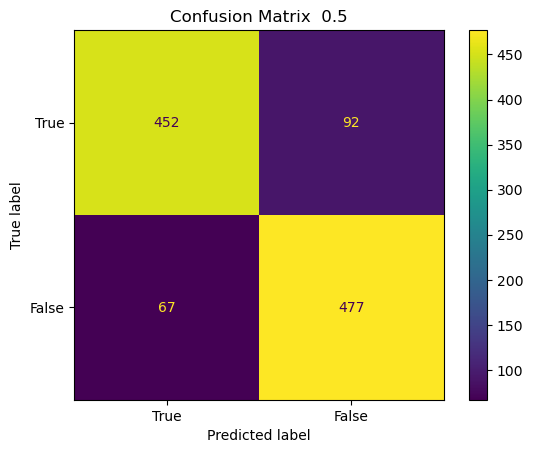

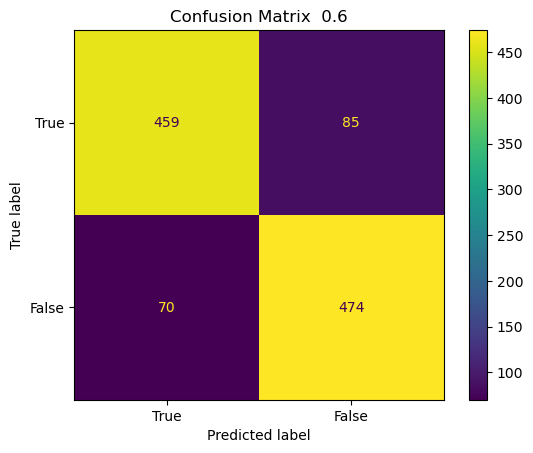

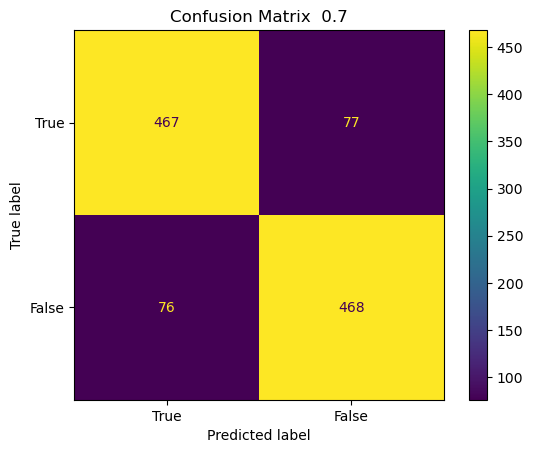

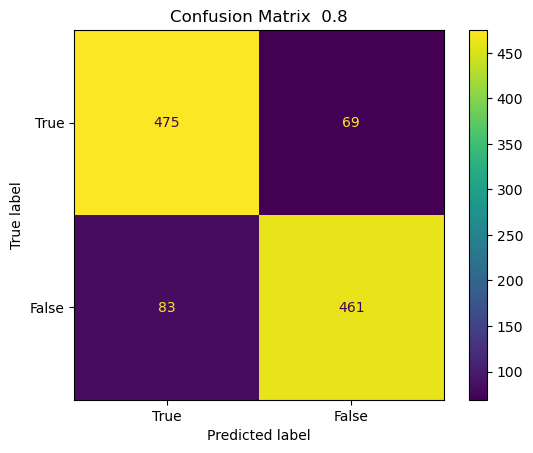

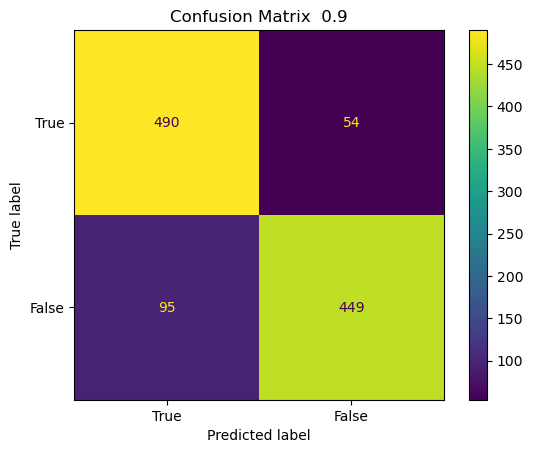

In [8]:

# Calculate mean F1 scores over all folds
mean_f1_scores = np.mean(fold_f1_scores, axis=0)
mean_fhalf_scores = np.mean(fold_half_scores, axis=0)
mean_fdouble_scores = np.mean(fold_double_scores, axis=0)
mean_recall = np.mean(fold_recalls, axis=0)
mean_precision = np.mean(fold_precisions, axis=0)

for i in range(len(thresholds)):
     print("Fold", i*0.1+0.1, "  Precision: ", fold_precisions[i], "  Recall: ", fold_recalls[i])
     print("F1 Score: ", fold_f1_scores[i], "F-0.5 Score: ", fold_half_scores[i], "F-2 Score: ", fold_double_scores)
     print()

print("  Mean precision: ", mean_precision, "  Mean recall: ", mean_recall)
print(" Mean F1 Score: ", mean_f1_scores)
print(" Mean F-0.5 Score: ", mean_fhalf_scores)
print(" Mean F-0.5 Score: ", mean_fdouble_scores)


#Print confusion matrix
import matplotlib.pyplot as metrics
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(len(fold_cm)):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = fold_cm[i], display_labels = [True, False])
    cm_display.plot()
    title = i * 0.1+0.1
     
    plt.title(f'Confusion Matrix {title: .1f}')
    plt.show()

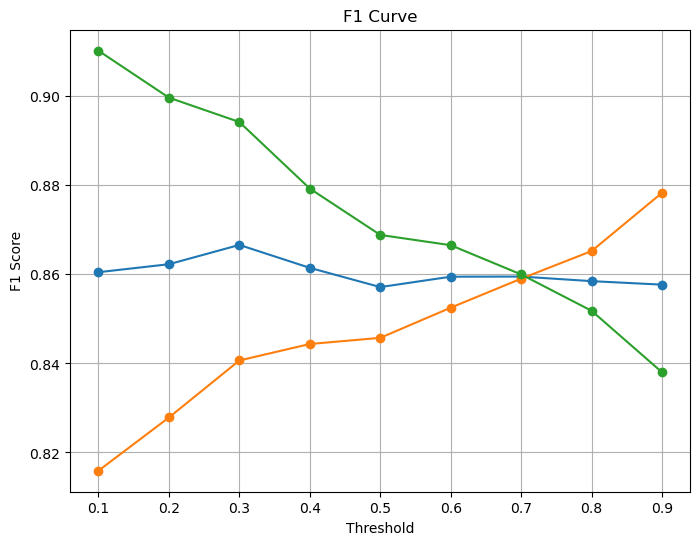

Mean F1 Score: 0.8603


In [9]:
#Plot the F1 curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fold_f1_scores, marker='o', linestyle='-')
plt.plot(thresholds, fold_half_scores, marker='o', linestyle='-')
plt.plot(thresholds, fold_double_scores, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.grid(True)
plt.show()

# Display the mean F1 score
print(f"Mean F1 Score: {mean_f1_scores:.4f}")

#pick 0.7 threshold



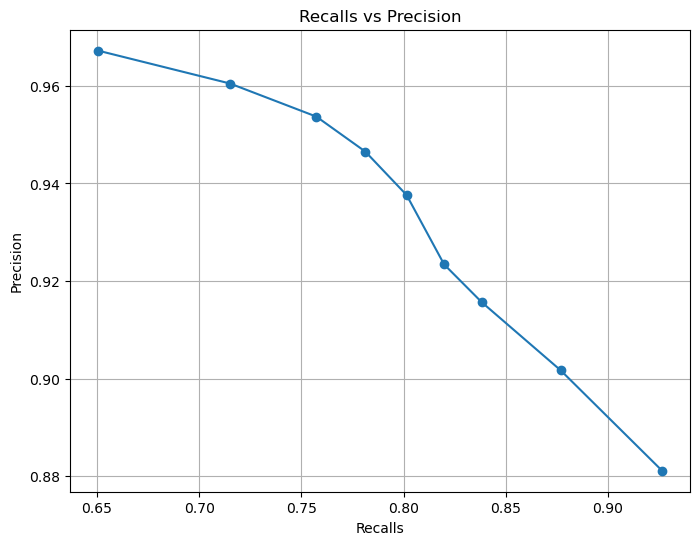

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(fold_recalls, fold_precisions, marker='o', linestyle='-')
plt.xlabel('Recalls')
plt.ylabel('Precision')
plt.title('Recalls vs Precision')
plt.grid(True)
plt.show()
